In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import importlib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style
import plotly.graph_objects as go

import util
import plot

# 1. Duration and balance of apn label

In [2]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

duration = []
pos_num, neg_num = 0, 0
patient_num = {'A': 0, 'B': 0, 'C': 0}
apn_duration = {'A': [], 'B': [], 'C': []}
for file in file_full:
    with open('data/processed/' + file + '.pkl', 'rb') as f:
        res = pickle.load(f)
        apn = res['apn']
        
    # Determine patient group
    if file[0] == 'x':
        group = util.ecg_diagnose(apn)
    else:
        group = file[0].upper()

    # Continuous apnea duration
    apn = np.array2string(apn.astype(int)) # Convert label to string 00011...
    apn = ''.join(re.split(' |\n',apn)) # Remove space and line break
    apn_duration[group].append(list(map(len, re.findall(r'1+', apn)))) # Length of continuous 1

    # Number of apnea and non-apnea minutes
    pos_num += len(re.findall(r'1', apn))
    neg_num += len(re.findall(r'0', apn))

    # Number of each diagnosis group
    patient_num[group] += 1 

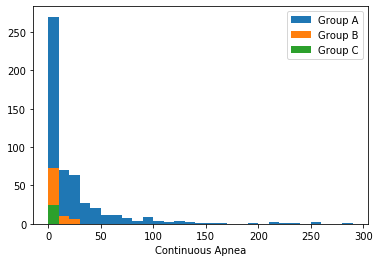

In [3]:
duration_A = np.hstack(apn_duration['A'])
duration_B = np.hstack(apn_duration['B'])
duration_C = np.hstack(apn_duration['C'])

plt.hist(duration_A, np.arange(0, 300, 10))
plt.hist(duration_B, np.arange(0, 300, 10))
plt.hist(duration_C, np.arange(0, 300, 10))
# plt.ylim((0, 50))
plt.legend(['Group A', 'Group B', 'Group C'])
plt.xlabel('Continuous Apnea')
plt.show()

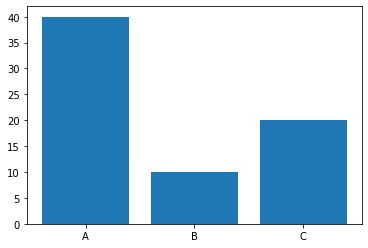

In [4]:
plt.bar(range(3), patient_num.values())
plt.xticks(range(3), labels=patient_num.keys())
plt.show()

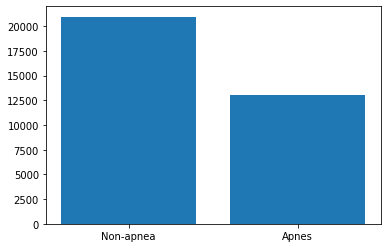

In [5]:
plt.bar([0, 1], [neg_num, pos_num])
plt.xticks([0, 1], labels=['Non-apnea', 'Apnes'])
plt.show()

## 1.1 Train-Test split

In [2]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = pd.DataFrame(columns=['file', 'group'])
for file in file_full:
    if file[0] == 'x':
        with open('data/raw/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']
            group = util.ecg_diagnose(apn)
    else:
        group = file[0].upper()
    
    df = df.append({
        'file': file,
        'group': group
    }, ignore_index=True)
        

In [9]:
df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df.group, random_state=123)

In [18]:
df_test.iloc[[1, 0, 4], :] # Select one sample from each group

,file,group
57,x23,A
37,x03,B
25,c01,C


In [19]:
df_test.to_csv('resources/File_test.csv', index=False)
df_train.to_csv('resources/File_train.csv', index=False)
df_test.iloc[[1, 0, 4], :].to_csv('resources/File_sample.csv', index=False)

In [20]:
df_test['group'].value_counts() / df['group'].value_counts()

A    0.2
C    0.2
B    0.2
Name: group, dtype: float64

# 2. Temporal features of heart rate
    Data to label mapping: Overlapping 3-min data to one label
    Data cleaning: Remove outliers (hr > 2), low pass filter
    Potential features: range, sd

In [2]:
from scipy import signal
b, a = signal.butter(3, 0.1)

In [3]:
def get_hr_range_sd(file_names):
    seg_num = 1 # Window size for feature extraction, should be odd number
    df= pd.DataFrame(columns=['range', 'std', 'apn', 'group', 'file'])

    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers (defined as hr > 2)
        idx_valid = hr < 2
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)

        # Extract range and sd for each 3-min window
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 
        for minute in range(len(apn) - seg_num + 1):
            try:
                data = hr_smth[(t_hr > minute) & (t_hr < minute + seg_num)]
                df = df.append({
                    'range': data.max() - data.min(),
                    'std': data.std(),
                    'apn': apn[minute + int(seg_num / 2)],
                    'group': group,
                    'file': file
                }, ignore_index=True)
            except:
                print(f'{file} at minute {minute} has no data')
        
    df['apn'] = df['apn'].astype(int)
    return df

In [4]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = get_hr_range_sd(file_full)

(0, 0.6)

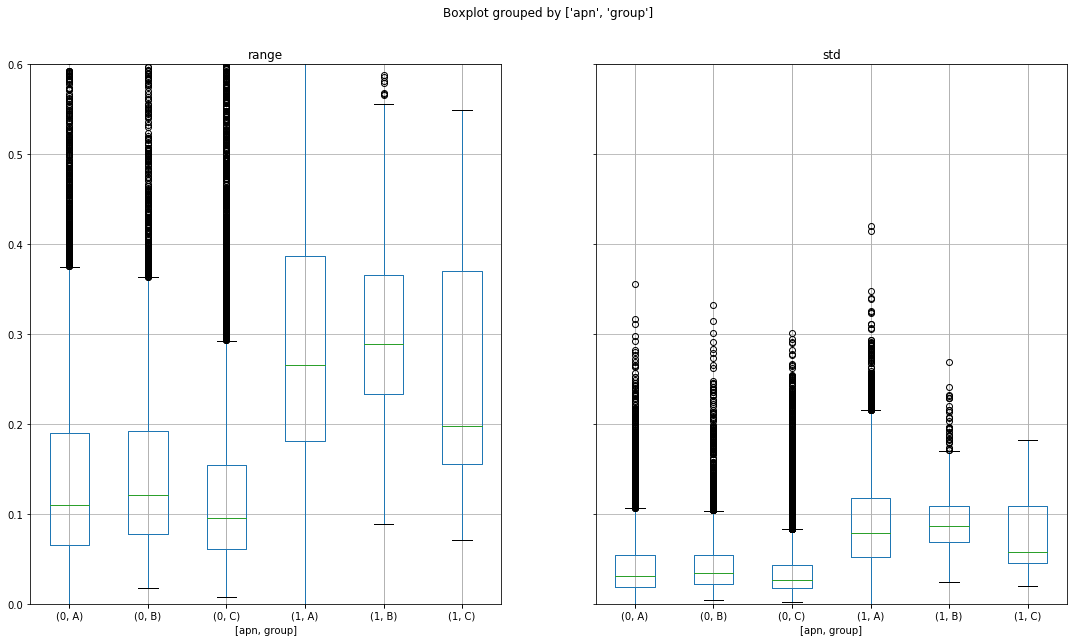

In [127]:
ax = df.boxplot(column=['range', 'std'], by=['apn', 'group'], figsize=(18,10))
ax[0].set_ylim(0, 0.6)
ax[1].set_ylim(0, 0.6)

## 2.1 Simple model

In [128]:
df.sample(5)

,range,std,apn,group,file
26603,0.166299,0.039928,0,A,x20
4358,0.104767,0.032814,0,A,a09
11499,0.220521,0.072232,0,B,b04
19135,0.248905,0.077288,1,A,x05
20056,0.055203,0.012325,0,A,x07


In [46]:
importlib.reload(util)

<module 'util' from 'C:\\Users\\joey3\\OneDrive\\CS_DS\\Apnea-ECG\\util.py'>

In [5]:
X_train, X_test, y_train, y_test, res = util.train_test_sample_split(df,['range', 'std'], 'apn')

In [6]:
mdl = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
print(metrics.classification_report(y_test, mdl.predict(X_test)))

y_train.value_counts()[0] / len(X_train)

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      4507
           1       0.57      0.30      0.39      2375

    accuracy                           0.68      6882
   macro avg       0.64      0.59      0.59      6882
weighted avg       0.66      0.68      0.65      6882



0.6069425999704884

In [7]:
res['mdl'] = mdl
with open('resources/logreg_time.pkl', 'wb') as f:
    pickle.dump(res, f)

# 3. Frequency features of heart rate

In [167]:
def get_hr_psd(file_names):
    seg_num = 3 # Window size for feature extraction, should be odd number
    fs_new = 2.4
    res_apn, res_psd = [], []
    
    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers (defined as hr > 2)
        idx_valid = hr < 2
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)

        # Resample data
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)

        # Extract range and sd for each 3-min window
        for minute in range(len(apn) - seg_num + 1):
            freqs, psd = signal.welch(
                x=hr_interp[(t_interp > minute) & (t_interp < minute + seg_num)], 
                fs=fs_new)
            res_psd.append(psd)
            res_apn.append(apn[minute + int(seg_num / 2)])
        
    res_psd = np.vstack(res_psd)
    res_apn = np.hstack(res_apn)
    return res_psd, res_apn, freqs


In [168]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

res_psd, res_apn, freqs = get_hr_psd(file_full)

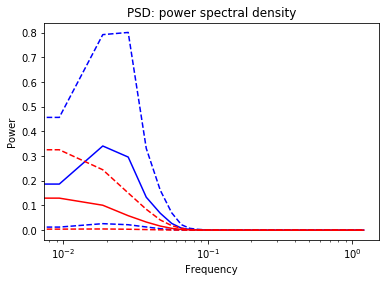

In [183]:
pos_mean = res_psd[res_apn==True].mean(axis=0)
neg_mean = res_psd[res_apn==False].mean(axis=0)
pos_90 = np.quantile(res_psd[res_apn==True], 0.9, axis=0)
pos_10 = np.quantile(res_psd[res_apn==True], 0.1, axis=0)
neg_90 = np.quantile(res_psd[res_apn==False], 0.9, axis=0)
neg_10 = np.quantile(res_psd[res_apn==False], 0.1, axis=0)

plt.semilogx(freqs, pos_mean, 'b-')
plt.semilogx(freqs, pos_90, 'b--')
plt.semilogx(freqs, pos_10, 'b--')
plt.semilogx(freqs, neg_mean, 'r-')
plt.semilogx(freqs, neg_90, 'r--')
plt.semilogx(freqs, neg_10, 'r--')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [185]:
freqs[np.argmax(pos_mean)]

0.01875

In [201]:
def get_hr_psd_features(file_names):
    seg_num = 7 # Window size for feature extraction, should be odd number
    fs_new = 2.4
    df= pd.DataFrame(columns=[
        'peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio', 'apn', 'group'])
    
    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers (defined as hr > 2)
        idx_valid = hr < 2
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)

        # Resample data
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)

        # Extract range and sd for each 3-min window
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 
        for minute in range(len(apn) - seg_num + 1):
            freqs, psd = signal.welch(
                x=hr_interp[(t_interp > minute) & (t_interp < minute + seg_num)], 
                fs=fs_new)
            df = df.append({
                'peak': psd.max(),
                'f_peak': freqs[np.argmax(psd)],
                'area_total': psd.sum(),
                'area_lf': psd[freqs < 1e-2].sum(),
                'area_hf': psd[freqs > 1e-2].sum(),
                'area_ratio': psd[freqs > 1e-2].sum() / psd[freqs < 1e-2].sum(),
                'apn': apn[minute + int(seg_num / 2)],
                'group': group,
            }, ignore_index=True)
        
    df['apn'] = df['apn'].astype(int)
    return df


In [202]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = get_hr_psd_features(file_full)

In [191]:
df.sample(5)

,peak,f_peak,area_total,area_lf,area_hf,area_ratio,apn,group
6971,0.281166,0.009375,1.006962,0.399658,0.607305,1.519563,1,A
30302,0.098763,0.009375,0.212903,0.119188,0.093716,0.786287,1,A
31745,1.768580,0.028125,3.009432,0.076168,2.933264,38.510292,1,A
10185,0.211703,0.018750,0.741398,0.103148,0.638250,6.187710,0,B
27602,0.487523,0.018750,1.251274,0.210181,1.041093,4.953312,1,A


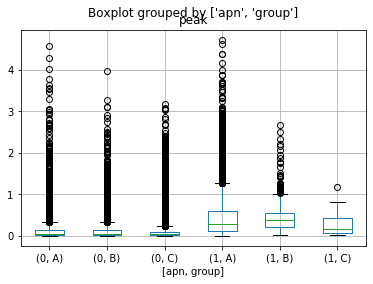

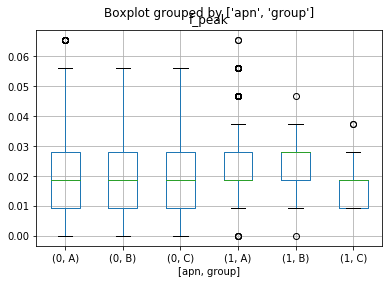

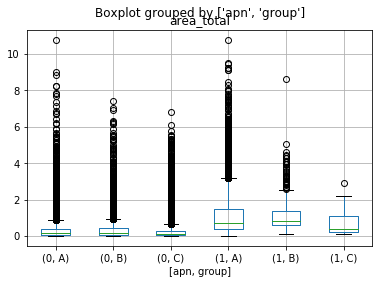

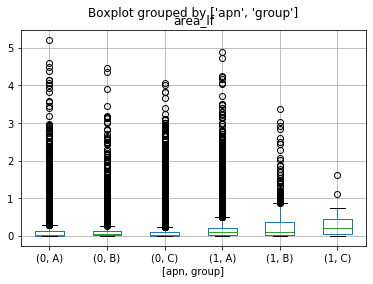

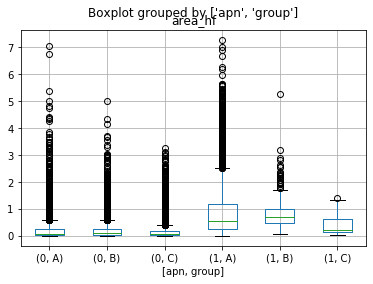

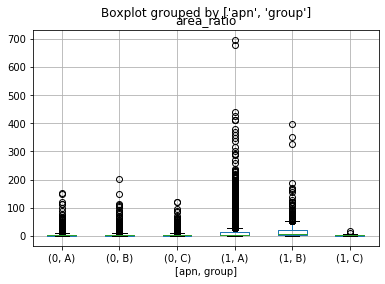

In [193]:
for feature in ['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio']:
    df.boxplot(column=[feature], by=['apn', 'group'])

## 3.1 Simple model

In [203]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio']],
    df['apn'], test_size=0.3, random_state=123, stratify=df['group'])
mdl = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
print(metrics.classification_report(y_test, mdl.predict(X_test)))

df_train['apn'].value_counts()[0] / len(df_train)

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      6218
           1       0.86      0.59      0.70      3853

    accuracy                           0.81     10071
   macro avg       0.82      0.77      0.78     10071
weighted avg       0.81      0.81      0.80     10071



0.5983881230116649

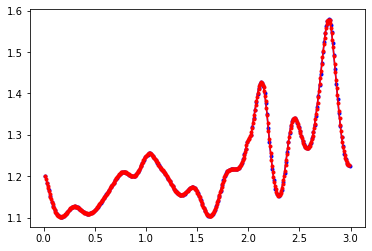

In [150]:
plt.plot(t, data, 'b.-')
plt.plot(t_new, data_new, 'r.-')